<a href="https://colab.research.google.com/github/naomifridman/DeepLearning_timeseries_introduction/blob/main/RNN_under_the_hood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to RNN

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_fig1.png)

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_fig2.png)

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_form1.png)

We can base predictions on top of ht by using just another matrix projection on top of the hidden state. This is the simplest complete case in which you can wire up a neural network:

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_form2.png)

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_form3.png)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
#from IPython.display import Image
from IPython.core.display import HTML 



import scipy.io as sio
import os
import time

from IPython.display import display, Markdown, Latex
import warnings
#warnings.filterwarnings('ignore')
import cv2
import os

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [18, 5]
pd.options.display.max_columns = 100

## Simple RNN handson example

### Predicting the next point in Sin  - Numpy RNN example

- Sequence input, original example is with text. 
- You can train RNNs using different vector representations. ("word2vec" "One-hot-vector", etc.)
- This is a slightly modified version of the original code(Karpathy). https://github.com/JY-Yoon
* Original code(Karpathy) : https://gist.github.com/karpathy/d4dee566867f8291f086

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_1to1.png)

## Create input signal

F 300.0 T 0.04 Fs 5000 Ts 0.0002 N 200


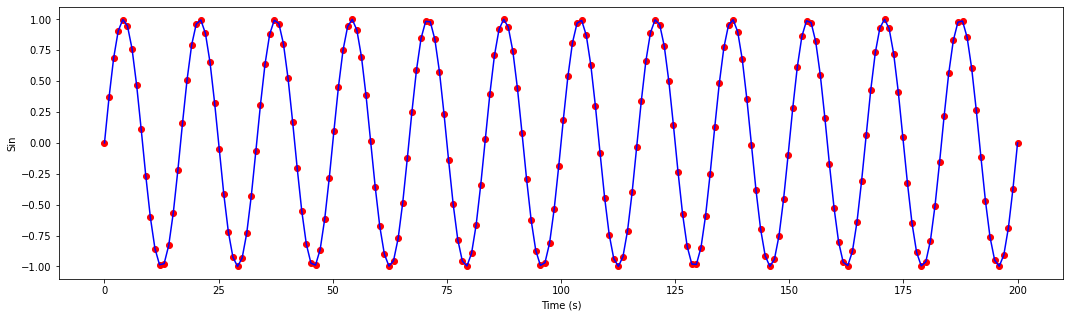

In [3]:
import numpy as np
import matplotlib.pyplot as plt

F = 300.          # No. of cycles per second, F = 300 Hz
T = 40.e-3        # Time period, T = 40 ms
Fs = 5000         # No. of samples per second, Fs = 50 kHz
Ts = 1./Fs        # Sampling interval, Ts = 20 us
N = int(T/Ts)     # No. of samples for 2 ms, N = 200

print('F', F, 'T', T, 'Fs', Fs, 'Ts', Ts, 'N',N)
# T time peried in miliseconds
# N number of samples (in T time interval)
# t time points, 
# signal - is the values of the sin in the time points
t = np.linspace(0, T, N)
signal = np.sin(2*np.pi*F*t)

plt.plot(t*N/T, signal, color='b')
plt.scatter(t*N/T, signal, color='r')
plt.xlabel('Time (s)')
plt.ylabel('Sin')
plt.show()

In [4]:
signal.shape

(200,)

In [5]:
x = ((signal+1)*10).astype(int)
x.shape

(200,)

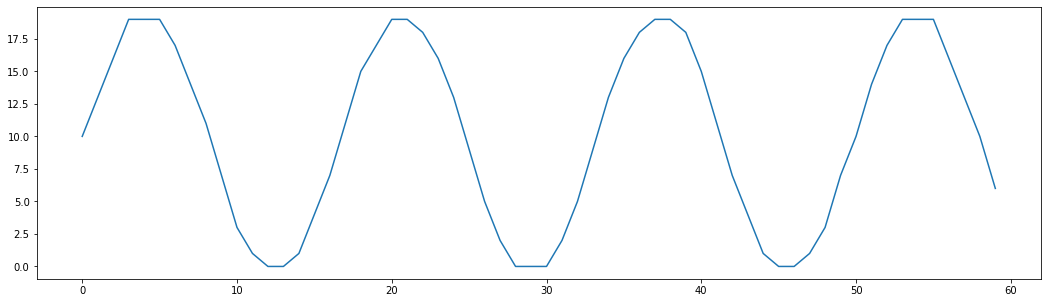

In [6]:
plt.plot(x[0:60])

In [7]:
np.unique(x), len(np.unique(x))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), 20)

In [8]:
x[0:20]

array([10, 13, 16, 19, 19, 19, 17, 14, 11,  7,  3,  1,  0,  0,  1,  4,  7,
       11, 15, 17])

# Initialization

In [9]:
char_to_int = dict((c, i) for i, c in enumerate(np.unique(x))) 
# "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(np.unique(x)))

In [10]:
# split and remove duplicate characters. convert to list.
chars = list(set(x)) 

# the number of unique characters
num_chars = len(chars) 
txt_data_size = len(x)
chars, num_chars, txt_data_size

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 20,
 200)

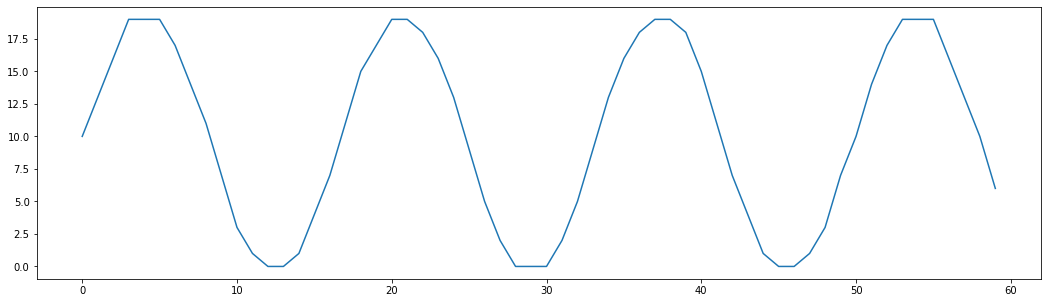

In [11]:
integer_encoded = [char_to_int[i] for i in x] 
plt.plot(integer_encoded[:60])

In [ ]:
batch_size = 20
x = x[:200]

In [12]:
# hyperparameters
txt_data_size = len(x)
print('txt data size: ', txt_data_size)
sequence_length = 10
print('sequence length: ', sequence_length)
batch_size = round((txt_data_size /sequence_length)+0.5) # = math.ceil
print('batch_size: ', batch_size)

learning_rate = 1e-1


# model parameters
hidden_size = 100  # size of hidden layer of neurons.  

W_xh = np.random.randn(hidden_size, num_chars)*0.01     # weight input -> hidden. 
W_hh = np.random.randn(hidden_size, hidden_size)*0.01   # weight hidden -> hidden
W_hy = np.random.randn(num_chars, hidden_size)*0.01     # weight hidden -> output

print('Sequence length (input size): ', sequence_length)
print('Number of Hidden units: ', hidden_size)
print('Weights: ', ' weight input -> hidden:', W_xh.shape)
print('Weights: ', ' weight hidden -> hidden:', W_hh.shape)
print('Weights: ', '  weight hidden -> output:', W_hh.shape)
b_h = np.zeros((hidden_size, 1)) # hidden bias
b_y = np.zeros((num_chars, 1)) # output bias

h_prev = np.zeros((hidden_size,1)) # h_(t-1)

txt data size:  200
sequence length:  10
batch_size:  20
Sequence length (input size):  10
Number of Hidden units:  100
Weights:   weight input -> hidden: (100, 20)
Weights:   weight hidden -> hidden: (100, 100)
Weights:    weight hidden -> output: (100, 100)


# Forward propagation

In [13]:
def forwardprop(inputs, targets, h_prev):
        
    xs, hs, ys, ps = {}, {}, {}, {} # dictionary
    
    # Copy previous hidden state vector to -1 key value.
    hs[-1] = np.copy(h_prev) 
    loss = 0 # loss initialization
    
    # t is a "time step" and is used as a key(dic). 
    for t in range(len(inputs)):  
        
        xs[t] = np.zeros((num_chars,1)) 
        xs[t][inputs[t]] = 1

        
        # hidden state.
        hs[t] = np.tanh(np.dot(W_xh, xs[t]) + np.dot(W_hh, hs[t-1]) + b_h) 
        
        # unnormalized log probabilities for next chars
        ys[t] = np.dot(W_hy, hs[t]) + b_y 
        
        # probabilities for next chars. 
        # Softmax. -> The sum of probabilities is 1 even without the exp() function, 
        # but all of the elements are positive through the exp() function.
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) 
        
        # softmax (cross-entropy loss). Efficient and simple code
        loss += -np.log(ps[t][targets[t],0]) 

    return loss, ps, hs, xs 

# Backward propagation

In [14]:
def backprop(ps, inputs, hs, xs):
    # make all zero matrices.
    dWxh, dWhh, dWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy) 
    dbh, dby = np.zeros_like(b_h), np.zeros_like(b_y)
    dhnext = np.zeros_like(hs[0]) # (hidden_size,1) 

    # reversed
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t]) # shape (num_chars,1).  "dy" means "dloss/dy"
        # backprop into y. After taking the soft max in the input vector, 
        # subtract 1 from the value of the element corresponding to the correct label.
        dy[targets[t]] -= 1 
        dWhy += np.dot(dy, hs[t].T)
        dby += dy 
        dh = np.dot(W_hy.T, dy) + dhnext # backprop into h. 
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(W_hh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: 
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients.  
    
    return dWxh, dWhh, dWhy, dbh, dby

# Training

In [15]:
data_pointer = 0
iteration = 900


# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 


for i in range(iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data
    
    for b in range(batch_size-1):
        
        inputs = [char_to_int[ch] for ch in x[data_pointer:data_pointer+sequence_length]]
        #print( 'training..  inputs:',len(inputs), inputs[0:2])
        inputs=np.array(inputs)
        #print(inputs.shape)
        targets = [char_to_int[ch] for ch in x[data_pointer+1:data_pointer+sequence_length+1]] # t+1        
        #print(b, 'training..  inputs:',inputs, ' \ntargets: ',targets)  
        #print(' targets: ',len(targets), targets[0:2])  
        targets=np.array(targets)

        # forward
        loss, ps, hs, xs = forwardprop(inputs, targets, h_prev)
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backprop(ps, inputs, hs, xs) 
        
        
    # perform parameter update with Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer

    if i % 100 == 0:
        print ('iter %d, loss: %f' % (i, loss)) # print progress



iter 0, loss: 39.554255
iter 100, loss: 1.201631
iter 200, loss: 0.906719
iter 300, loss: 0.837780
iter 400, loss: 0.807404
iter 500, loss: 0.790231
iter 600, loss: 0.778961
iter 700, loss: 0.770857
iter 800, loss: 0.764663


In [18]:
loss

0.7597769851978888

# Prediction

In [19]:
def predict(test_char, length):
    xn = np.zeros((num_chars, 1)) 
    xn[char_to_int[test_char]] = 1
    ixes = []
    h = np.zeros((hidden_size,1))

    for t in range(length):
        h = np.tanh(np.dot(W_xh, xn) + np.dot(W_hh, h) + b_h) 
        y = np.dot(W_hy, h) + b_y
        p = np.exp(y) / np.sum(np.exp(y)) 
        
        ix=np.argmax(p)
        #ix = np.random.choice(range(num_chars), p=p.ravel()) # ravel -> rank0
        # "ix" is a list of indexes selected according to the soft max probability.
        x = np.zeros((num_chars, 1)) # init
        x[ix] = 1 
        ixes.append(ix) # list
        xn = np.zeros((num_chars, 1)) 
        test_char_ix = ix
        xn[ix] = 1
    pred = [int_to_char[i] for i in ixes]
    
    return pred

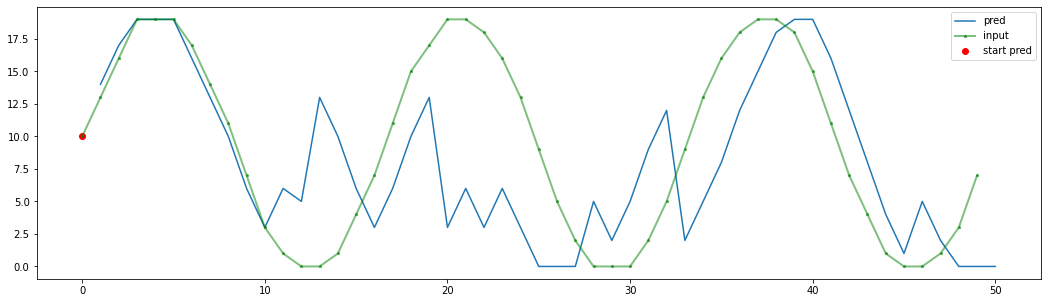

In [20]:
pred = predict(x[0],50)
plt.plot(np.arange(1, len(pred)+1),pred, label='pred')
plt.scatter([0],[char_to_int[x[0]]], color='r', label='start pred')
plt.plot([char_to_int[c] for c in x[0:50]], marker='*', color='g', 
         lw=2, markersize=3, label='input', alpha=0.5)
plt.legend()

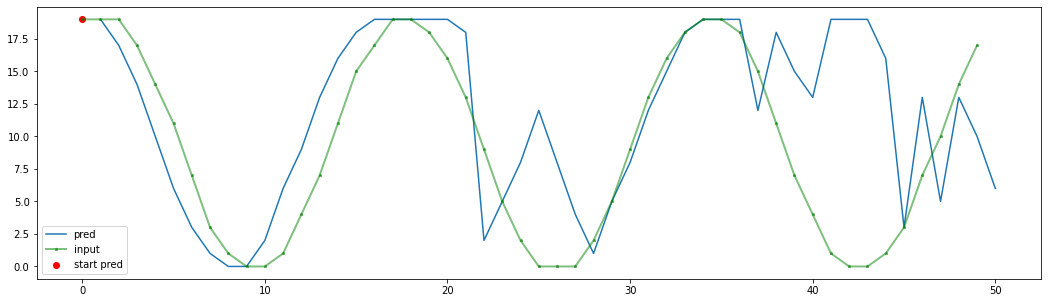

In [21]:
pred = predict(x[3],50)
plt.plot(np.arange(1, len(pred)+1),pred, label='pred')
plt.scatter([0],[char_to_int[x[3]]], color='r', label='start pred')
plt.plot([char_to_int[c] for c in x[3:53]], marker='*', color='g', 
         lw=2, markersize=3, label='input', alpha=0.5)
plt.legend()

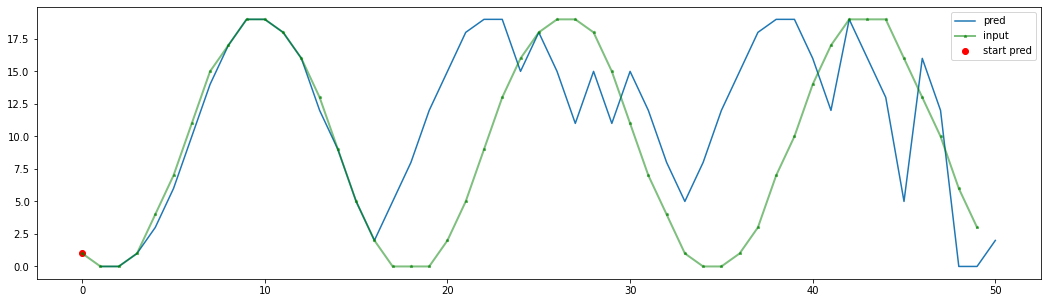

In [22]:
pred = predict(x[11],50)
#print(pred)
plt.plot(np.arange(1, len(pred)+1),pred, label='pred')
plt.scatter([0],[char_to_int[x[11]]], color='r', label='start pred')
plt.plot([char_to_int[c] for c in x[11:61]], marker='*', color='g', 
         lw=2, markersize=3, label='input', alpha=0.5)
#plt.plot(range(10,30), x[10:30], marker='*', color='gray', lw=2, markersize=20)
plt.legend()

# RNN different architectures for different tasks

![title](one_to_many.png)

# Lets play with Simple RNN
## Many to one

![title](https://raw.githubusercontent.com/naomifridman/DeepLearning_timeseries_introduction/master/images/rnn_mto1.png)

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, Lambda
#adam = optimizers.Adam(lr)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, RNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import TimeDistributed, Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D, BatchNormalization
from keras.models import Model
from tensorflow.keras import optimizers

### Create Input Signal

F 300.0 T 0.04 Fs 5000 Ts 0.0002 N 200


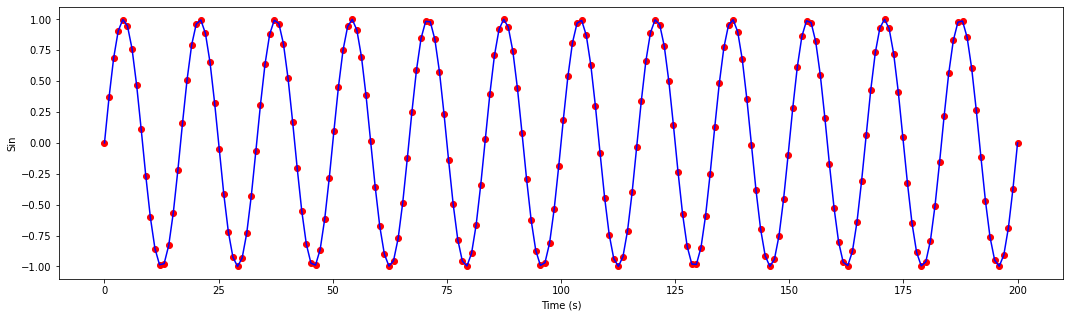

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

F = 300.          # No. of cycles per second, F = 300 Hz
T = 40.e-3        # Time period, T = 40 ms
Fs = 5000         # No. of samples per second, Fs = 50 kHz
Ts = 1./Fs        # Sampling interval, Ts = 20 us
N = int(T/Ts)     # No. of samples for 2 ms, N = 200

print('F', F, 'T', T, 'Fs', Fs, 'Ts', Ts, 'N',N)
# T time peried in miliseconds
# N number of samples (in T time interval)
# t time points, 
# signal - is the values of the sin in the time points
t = np.linspace(0, T, N)
signal = np.sin(2*np.pi*F*t)

plt.plot(t*N/T, signal, color='b')
plt.scatter(t*N/T, signal, color='r')
plt.xlabel('Time (s)')
plt.ylabel('Sin')
plt.show()

In [ ]:
signal.shape

(200,)

In [ ]:
# normalize signal
x = signal+1

x = np.concatenate([x[:-1] for i in range(50)])/2.
x.shape

(9950,)

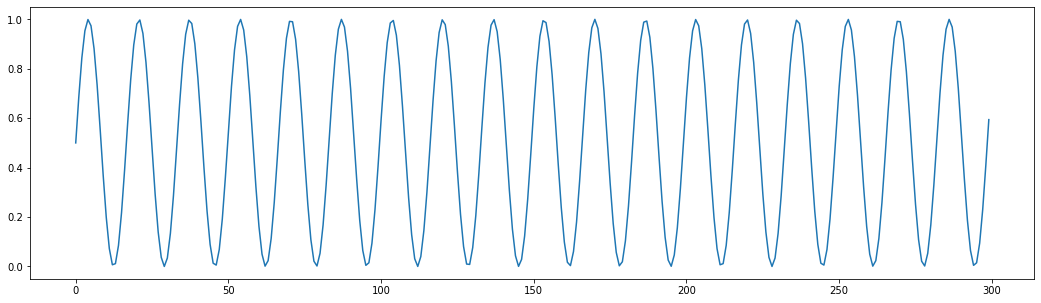

In [ ]:
plt.plot(x[:300])

In [ ]:
input_signal = x.copy()

### Create model train data using keras timeseries_dataset_from_array

In [ ]:
import numpy as np
import tensorflow as tf
#from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


(10, 120) (10,)


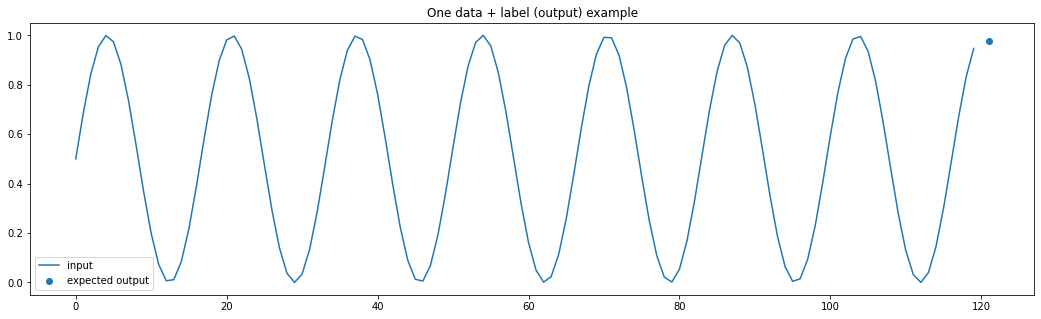

In [ ]:
train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=x[:1200], 
    targets=x[121:1200+121], 
    sequence_length=120,
    batch_size=10)

val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=x[1200:2400], 
    targets=x[121+1200:2400+121], 
    sequence_length=120,
    batch_size=10)

for batch in train_dataset:
    inputs, targets = batch
    print(inputs.shape, targets.shape)
    plt.plot(inputs[0], label='input')
    plt.scatter(x=121,y=targets[0], label='expected output')
    plt.title('One data + label (output) example')
    plt.legend()
    break

In [ ]:
num_features = 1
steps = 120
inputs = Input(shape=(steps, num_features))
l = SimpleRNN(20, return_sequences=False)(inputs)

outputs = Dense(1, activation='relu')(l)
model = Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 1)]          0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20)                440       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [ ]:

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=2,
                    validation_data=val_dataset)

Epoch 1/2
109/109 [==============================] - 8s 64ms/step - loss: 0.0011 - mae: 0.0242 - val_loss: 0.0020 - val_mae: 0.0406
Epoch 2/2
109/109 [==============================] - 7s 63ms/step - loss: 8.2551e-04 - mae: 0.0225 - val_loss: 0.0076 - val_mae: 0.0677


In [ ]:
tst = input_signal[1200:1200+120].reshape(1,120,1)
pred = model.predict(tst)
pred

array([[0.18415168]], dtype=float32)

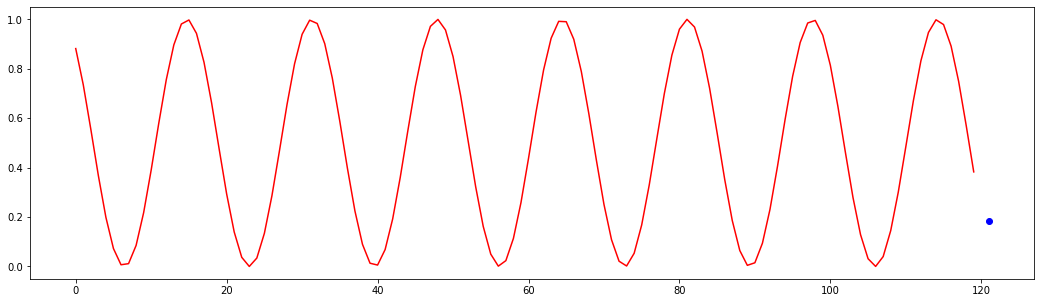

In [ ]:
plt.plot(np.squeeze(tst), color='r', label='input');
plt.scatter(x=121,y=pred[0], label='predicted output', color='b');

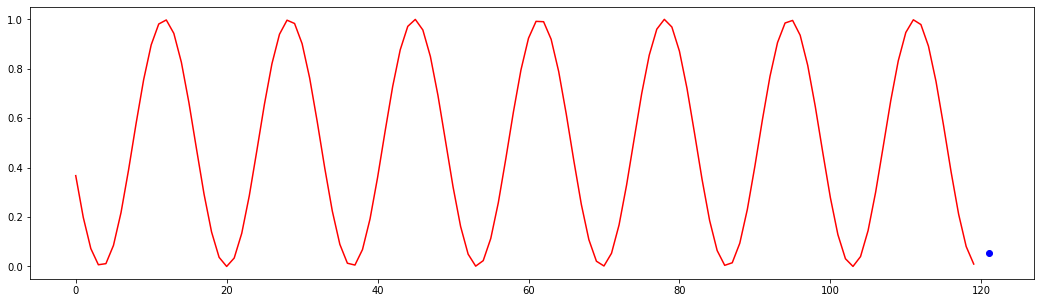

In [ ]:
tst = input_signal[1800:1800+120].reshape(1,120,1)
pred = model.predict(tst)
plt.plot(np.squeeze(tst), color='r', label='input');
plt.scatter(x=121,y=pred[0], label='predicted output', color='b');

# RNN Drowbacks

# LSTM